# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `dataproject.py` file includes a function which will be used multiple times in this notebook.

Imports and set magics:

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2 

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import dataproject

# import pydst
import pydst
dst = pydst.Dst(lang='en')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data

## Employment data

**Read the employment data** in ``RAS200.xlsx`` and **clean it** removing and renaming columns:

In [141]:
educ_vars = dst.get_variables(table_id='HFUDD10')
educ_vars

#a. Download data
educ = dst.get_data(table_id = 'HFUDD10', variables={'Tid':['*'],'HERKOMST':['*'], 'HFUDD':['TOT','H30', 'H40', 'H50', 'H60', 'H70'], 'KØN':['*']})
educ.head(10)

# b. drop columns
drop_these = ['BOPOMR','ALDER']
educ.drop(drop_these, axis=1, inplace=True)
educ.head(10)


# c. rename columns
educ.rename(columns = {'HERKOMST':'Ancestry','HFUDD':'HCEDUC', 'KØN':'Gender', 'TID':'Year', 'INDHOLD':'Units'}, inplace=True)
educ.head(10)

# d. Clean values in HCEDUC
educ['HCEDUC']=educ.HCEDUC.astype(str).str[4:]
educ.head(20)



,Year,Ancestry,HCEDUC,Gender,Units
0,2006,Descendant,Vocational Education and Training (VET),Women,1938
1,2006,Descendant,Vocational Education and Training (VET),Men,1756
2,2006,Descendant,Vocational Education and Training (VET),Total,3694
3,2006,Descendant,Short cycle higher education,Women,314
4,2006,Descendant,Short cycle higher education,Men,370
5,2006,Descendant,Short cycle higher education,Total,684
6,2006,Descendant,Vocational bachelors educations,Women,829
7,2006,Descendant,Vocational bachelors educations,Men,509
8,2006,Descendant,Vocational bachelors educations,Total,1338
9,2006,Descendant,Bachelors programmes,Women,302


In [142]:
# educ.groupby(['Year','Ancestry']).describe()



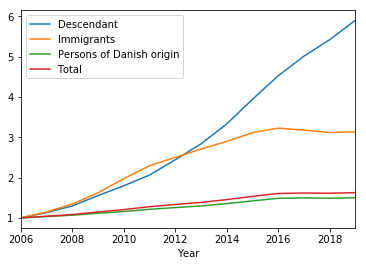

In [143]:
for val in ['Men', 'Women']: 
    I = educ.Gender.str.contains(val)
    educ = educ.loc[I == False] # keep everything else

educ1 = educ.copy()

# a. split
educ_grouped = educ1.groupby(['Ancestry','HCEDUC'])
educ_grouped_first = educ_grouped.Units.first()
educ_grouped_first.name = 'first'

# b. apply
educ1.set_index(['Ancestry','HCEDUC'],inplace=True)
educ1 = educ1.join(educ_grouped_first,how='left',on=['Ancestry','HCEDUC'])
educ1.reset_index(inplace=True)

# c. combine
educ1['indexed'] = educ1['Units']/educ1['first']

# d. plot
def plot(df):
    df_indexed = df.set_index(['Year'])
    I = df_indexed.HCEDUC == 'Bachelors programmes'
    df_indexed[I].groupby(['Ancestry'])['indexed'].plot(legend=True);
    
plot(educ1)

# Stack plot

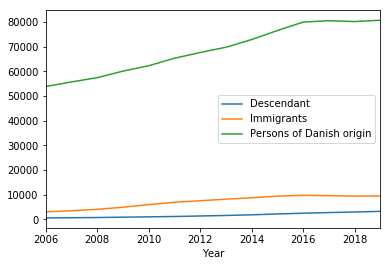

In [146]:
educ2 = educ.copy()

#
I = educ2.Ancestry.str.contains('Total')
educ2 = educ2.loc[I == False] 


#Split
#educ_grouped = educ2.groupby(['Ancestry','HCEDUC'])

def plot2(df):
    df = df.set_index(['Year'])
    I = df.HCEDUC == 'Bachelors programmes'
    df = df[I].groupby(['Ancestry'])['Units']
    df.plot(legend=True);
    
plot2(educ2)

## Income data

**Read the income data** in ``INDKP101.xlsx`` and **clean it**:

In [ ]:
# a. load
#inc = pd.read_excel('INDKP101.xlsx', skiprows=2)

# b. drop and rename columns
#inc.drop([f'Unnamed: {i}' for i in range(3)], axis=1, inplace=True)
#inc.rename(columns = {'Unnamed: 3':'municipality'}, inplace=True)

# c. drop rows with missing
#inc.dropna(inplace=True)

# d. remove non-municipalities
#inc = dataproject.only_keep_municipalities(inc)

# e. convert to long
#inc.rename(columns = {str(i):f'income{i}' for i in range(1986,2018)}, inplace=True)
#inc_long = pd.wide_to_long(inc, stubnames='income', i='municipality', j='year').reset_index()

# f. show
#inc_long.head(5)

> **Note:** The function ``dataproject.only_keep_municipalities()`` is used on both the employment and the income datasets.

## Explore data set

In order to be able to **explore the raw data**, we here provide an **interactive plot** to show, respectively, the employment and income level in each municipality

The **static plot** is:

In [ ]:
def plot_empl_inc(empl,inc,dataset,municipality): 
    
    if dataset == 'Employment':
        df = empl
        y = 'employment'
    else:
        df = inc
        y = 'income'
    
    I = df['municipality'] == municipality
    ax = df.loc[I,:].plot(x='year', y=y, style='-o')

The **interactive plot** is:

In [ ]:
widgets.interact(plot_empl_inc, 
    
    empl = widgets.fixed(empl_long),
    inc = widgets.fixed(inc_long),
    dataset = widgets.Dropdown(description='Dataset', 
                               options=['Employment','Income']),
    municipality = widgets.Dropdown(description='Municipality', 
                                    options=empl_long.municipality.unique())
                 
); 

ADD SOMETHING HERE IF THE READER SHOULD KNOW THAT E.G. SOME MUNICIPALITY IS SPECIAL.

# Merge data sets

We now create a data set with **municpalities which are in both of our data sets**. We can illustrate this **merge** as:

In [ ]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('inc', 'empl'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

In [ ]:
merged = pd.merge(empl_long, inc_long, how='inner',on=['municipality','year'])

print(f'Number of municipalities = {len(merged.municipality.unique())}')
print(f'Number of years          = {len(merged.year.unique())}')

# Analysis

To get a quick overview of the data, we show some **summary statistics by year**:

In [ ]:
merged.groupby('year').agg(['mean','std']).round(2)

ADD FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.